In [1]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import time
from skimage.color import lab2rgb, ycbcr2rgb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from importlib import reload
import loss
import data_generator
import model
import train
import visualize
reload(loss)
reload(visualize)
reload(model)
reload(data_generator)
reload(train)

from data_generator import make_dataloaders
from model import MainModel
from train import train_model, load_model

In [2]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [3]:
COLOR_SPACE = 'Lab' # Lab or HSL
path = "./data/part1"
model_path = f"./models/model_cropped_faces_{COLOR_SPACE}.pt"
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 1000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(1000)
train_idxs = rand_idxs[:800] # choosing the first 8000 as training set
val_idxs = rand_idxs[800:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

800 200


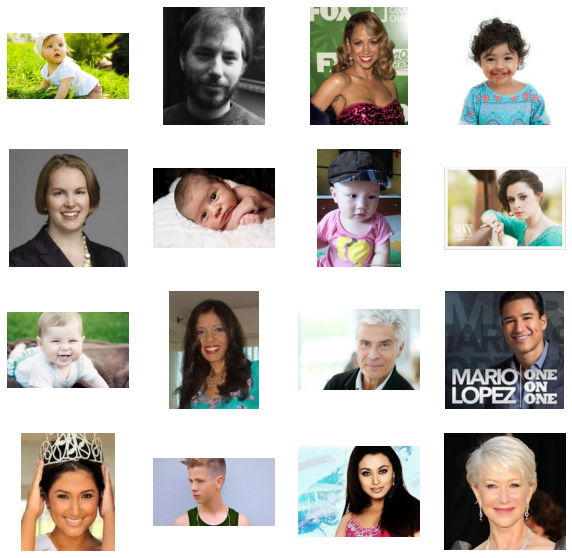

In [4]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [5]:
train_dl = make_dataloaders(paths=train_paths, split='train', color_space=COLOR_SPACE)
val_dl = make_dataloaders(paths=val_paths, split='val', color_space=COLOR_SPACE)

data = next(iter(train_dl))
known_channels, unknown_channels_ = data['known_channel'], data['unknown_channels']
print(known_channels.shape, unknown_channels_.shape)
print(len(train_dl), len(val_dl))

C:\Anaconda\lib\site-packages\torchvision\transforms\transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
50 13


In [6]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [7]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [8]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['known_channel'].to(device), data['unknown_channels'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [ ]:

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = torch.optim.Adam(net_G.parameters(), lr=1e-4)
criterion = torch.nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 1)

In [ ]:
torch.save(net_G.state_dict(), "res18-unet.pt")

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))

In [ ]:
model = MainModel()
train_model(model, train_dl, val_dl, COLOR_SPACE, 2, 10)

In [ ]:
from visualize import visualize

loaded_model = MainModel()
_, loss_meter_dict = load_model(model_path, loaded_model)
for i, data in enumerate(iter(val_dl)):
    visualize(loaded_model, data, COLOR_SPACE, save=False)
    if i == 4:
        break